# Read and process soil water content sensors


location of soil sensors and their numbers											
						
|Port| Sensor No | Place| depth | mTAW |
|:-----------:|:-----------:|:--------------------:|:--------------------------------:|:---------------:|
|   1   |  37   |  1 | 70 |  
|   2   |  3    |  1 | 40 |  
|   4   |  28   |  1 | 20 |  
|   5   |  41   |  2 | 70 | 
|   7   |  29   |  2 | 20 | 
|   8   |  4  |  2 | 40 | 
|   10  |  x   |  3 | x |  
|   11  |  x   |  3 | x |  
|   12  |  x   |  3 | x | 


# Import Python modules

In [2]:
import pandas as pd
import xlrd
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
#from pandasql import sqldf
import datetime
import csv
import pdb
from tqdm.notebook import tqdm
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FuncFormatter
from matplotlib.legend import Legend
def minor_formatter(x, ind):
    # only format if we don't overlap with a major tick
    if np.mod(x, 1) < .1:
        return ''
    return '{:.1f}'.format(np.mod(x, 1))
def alternate_formatter(x, ind):
    rm = np.mod(x, 1)
    if np.abs(rm) < .1:
        return '{:d}'.format(int(x))
    return '{:.1f}'.format(rm)

# Read data file

In [3]:
path1 = os.getcwd()
path = os.path.join(path1, 'Data_Callibration')
file = os.path.join(path, 'RawData.csv')
Cal = pd.read_csv(file,sep=';', header=0)
print(Cal)

    SensorNumber   RawValue  KnownVWC
0              7  27.192825     0.353
1              7  25.560288     0.254
2              7  23.913115     0.209
3             28  27.711502     0.353
4             28  26.337332     0.254
5             28  24.516957     0.209
6             41  28.118244     0.353
7             41  26.337332     0.254
8             41  24.753454     0.209
9             43  27.192825     0.353
10            43  25.218349     0.254
11            43  23.913115     0.209
12             3  28.418761     0.353
13             3  26.337332     0.254
14             3  25.446928     0.209
15            29  28.418761     0.353
16            29  25.673040     0.254
17            29  24.635553     0.209
18             4  28.617026     0.353
19             4  26.446092     0.254
20             4  25.332952     0.209
21            37  28.218839     0.353
22            37  26.554316     0.254
23            37  25.103109     0.209
24             5  28.319010     0.353
25          

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

KV = Cal['KnownVWC']
RV = pd.to_numeric(Cal.RawValue)
SN = Cal.SensorNumber
df = pd.DataFrame(dict(KnownVWC = KV, RawValue=RV, SensorNumber = SN))
print(df)

plt.show()

    KnownVWC   RawValue  SensorNumber
0      0.353  27.192825             7
1      0.254  25.560288             7
2      0.209  23.913115             7
3      0.353  27.711502            28
4      0.254  26.337332            28
5      0.209  24.516957            28
6      0.353  28.118244            41
7      0.254  26.337332            41
8      0.209  24.753454            41
9      0.353  27.192825            43
10     0.254  25.218349            43
11     0.209  23.913115            43
12     0.353  28.418761             3
13     0.254  26.337332             3
14     0.209  25.446928             3
15     0.353  28.418761            29
16     0.254  25.673040            29
17     0.209  24.635553            29
18     0.353  28.617026             4
19     0.254  26.446092             4
20     0.209  25.332952             4
21     0.353  28.218839            37
22     0.254  26.554316            37
23     0.209  25.103109            37
24     0.353  28.319010             5
25     0.254

In [5]:
file = os.path.join(path, 'dacom_weather_data.csv')
#climate data from  www.dacom.nl
clim=pd.read_csv(file,sep=';')
clim['date'] = pd.to_datetime(clim['date'], format = '%m/%d/%Y')
print(clim)

climday = clim.groupby(clim.date.dt.floor('d')).agg({'precipitation': ['sum']})
climday.columns  = ['_'.join(col) for col in climday.columns.values]
climday.reset_index(inplace=True)
print(climday)


           date      time  air_temperature  rel_humidity  precipitation  \
0    2022-05-17  12:00 AM            15.57         90.16            0.0   
1    2022-05-17   1:00 AM            15.20         95.71            0.0   
2    2022-05-17   2:00 AM            15.11         97.59            0.0   
3    2022-05-17   3:00 AM            14.91         92.53            0.0   
4    2022-05-17   4:00 AM            14.72        100.00            0.0   
...         ...       ...              ...           ...            ...   
6754 2023-02-22   9:00 AM             4.66        100.00            0.0   
6755 2023-02-22  10:00 AM             6.18        100.00            0.0   
6756 2023-02-22  11:00 AM             8.22        100.00            0.2   
6757 2023-02-22  12:00 PM             8.91        100.00            0.0   
6758 2023-02-22   1:00 PM             8.96        100.00            0.0   

      wind_speed  wind_direction  radiation  radiation_short  
0           0.54          164.34    

# Plot data

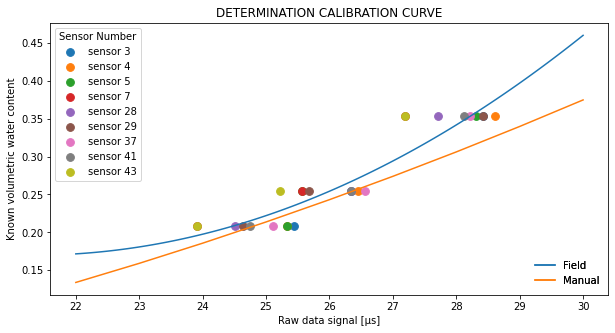

          2
0.003844 x - 0.1638 x + 1.916
0.8835858446749271


In [6]:
from sklearn.metrics import r2_score
import scipy.stats as stats

xx = np.arange(22,31)
yy = 0.0007*xx**2 - 0.0063*xx - 0.0663

model = np.poly1d(np.polyfit(Cal['RawValue'],
                             Cal['KnownVWC'], 2))
polyline = np.linspace(22, 30, 100)
fig, ax = plt.subplots(figsize=(10,5))


for i in range(44):
    if(i not in Cal.SensorNumber.tolist()):
        continue
    else:
        sensorMeasurements = Cal.loc[Cal['SensorNumber'] == i]
        scatter = ax.scatter(sensorMeasurements.RawValue, sensorMeasurements.KnownVWC, label=f"sensor {i}"
            , alpha=1, s=60)

legend = ax.legend(title="Sensor Number")
ax.add_artist(legend)

field, = plt.plot(polyline, model(polyline))
manual, = plt.plot(xx,yy)


leg = ax.legend( handles = [field, manual], labels = ['Field', 'Manual'],
               loc='lower right', frameon=False)
ax.add_artist(leg);

ax.set_ylabel('Known volumetric water content')
ax.set_xlabel('Raw data signal [µs]')
ax.set_title('DETERMINATION CALIBRATION CURVE')

plt.show()

print(model)
print(r2_score(Cal['KnownVWC'], 
               model(Cal['RawValue'])))
  

# Import field data

In [7]:
path1 = os.getcwd()
path = os.path.join(path1, 'Data_Callibration')
file = os.path.join(path, 'FieldData3.csv')
Field = pd.read_csv(file,sep=';', header=0)
Field1 = Field.iloc[:,0:38]
Data = Field1.iloc[:,[5,7,9,11,13,15,17,19,21,23,27,29,33,35,37]]
Data = Data.replace('NAN',np.nan)
Data = Data.fillna(0)
Data = Data.astype(float)
#Data['PA_uS_Avg(7)'] = Data['PA_uS_Avg(7)'] + Data['PA_uS_Avg(3)']
#Data['PA_uS_Avg(8)'] = Data['PA_uS_Avg(8)'] + Data['PA_uS_Avg(6)']
#Data.loc[:40,'PA_uS_Avg(3)'] = 0
#Data.loc[:40,'PA_uS_Avg(6)'] = 0
print(Data)
Data.to_excel('RawSignals.xlsx')

## !!!!!!!!!!!!Data format van de datum moet hetzelfde zijn als deze van de weer data

C:\Users\brasp\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (5,7,9,10,11,12,13,15,16,17,18,19,22,23,27,28,29,30,31,34,35,42,43,76,77,78,79,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,129,131,133,135,137,139,140,141,142,143,145,147,149,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


      PA_uS_Avg(1)  PA_uS_Avg(2)  PA_uS_Avg(3)  PA_uS_Avg(4)  PA_uS_Avg(5)  \
0            26.74         24.24          0.00          0.00          0.00   
1            27.16         26.50          0.00         25.39         25.83   
2            27.17         26.50          0.00         25.40         25.84   
3            27.18         26.50          0.00         25.40         25.84   
4            27.18         26.51          0.00         25.41         25.85   
...            ...           ...           ...           ...           ...   
7430         30.22         28.77         29.63         28.29         31.07   
7431         30.22         28.77         29.63         28.29         31.07   
7432         30.22         28.77         29.63         28.29         31.07   
7433         30.22         28.77         29.62         28.29         31.07   
7434         30.22         28.77         29.63         28.29         31.07   

      PA_uS_Avg(6)  PA_uS_Avg(7)  PA_uS_Avg(8)  PA_uS_Avg(9)  P

# Calculate volumetric water content

In [8]:
c=len(Data.columns) 
print(c)
r=len(Data)
print(r)
ColumnNumber = list(range(0, c))
print(ColumnNumber)
VWC = np.zeros((r,c))
print(VWC)

15
7435
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [9]:
for i in ColumnNumber:
    VWC[:,i] = 0.003844*Data.iloc[:,i]**2 - 0.1638*Data.iloc[:,i] + 1.916
print(VWC)

[[0.28455409 0.20413629 1.916      ... 1.916      1.916      1.916     ]
 [0.30277857 0.274749   1.916      ... 1.916      1.916      1.916     ]
 [0.30322901 0.274749   1.916      ... 1.916      1.916      1.916     ]
 ...
 [0.47649085 0.38520239 0.43739544 ... 1.916      0.60165875 1.916     ]
 [0.47649085 0.38520239 0.43675587 ... 1.916      0.60165875 1.916     ]
 [0.47649085 0.38520239 0.43739544 ... 1.916      0.60165875 1.916     ]]


In [10]:
VWC[VWC>1] = np.nan
print(VWC)

[[0.28455409 0.20413629        nan ...        nan        nan        nan]
 [0.30277857 0.274749          nan ...        nan        nan        nan]
 [0.30322901 0.274749          nan ...        nan        nan        nan]
 ...
 [0.47649085 0.38520239 0.43739544 ...        nan 0.60165875        nan]
 [0.47649085 0.38520239 0.43675587 ...        nan 0.60165875        nan]
 [0.47649085 0.38520239 0.43739544 ...        nan 0.60165875        nan]]


In [11]:
VWC = pd.DataFrame(VWC)
VWC.columns =['a70','a40','d20/1','a20','b70','d40/1','b20','b40','d70/1','d20/2','d20/3','d40/3','d40/2','d70/3','d70/2']
print(VWC)

           a70       a40     d20/1       a20       b70     d40/1       b20  \
0     0.284554  0.204136       NaN       NaN       NaN       NaN  0.182871   
1     0.302779  0.274749       NaN  0.235161  0.249720       NaN  0.238339   
2     0.303229  0.274749       NaN  0.235475  0.250068       NaN  0.238661   
3     0.303680  0.274749       NaN  0.235475  0.250068       NaN  0.238661   
4     0.303680  0.275149       NaN  0.235790  0.250417       NaN  0.238984   
...        ...       ...       ...       ...       ...       ...       ...   
7430  0.476491  0.385202  0.437395  0.358544  0.537520  0.392727  0.403361   
7431  0.476491  0.385202  0.437395  0.358544  0.537520  0.393311  0.403361   
7432  0.476491  0.385202  0.437395  0.358544  0.537520  0.392727  0.403361   
7433  0.476491  0.385202  0.436756  0.358544  0.537520  0.393311  0.403361   
7434  0.476491  0.385202  0.437395  0.358544  0.537520  0.393311  0.403361   

           b40     d70/1     d20/2     d20/3     d40/3  d40/2  

In [12]:
Plotdata = Field1.iloc[:,0]
print(Plotdata)

0       2022-09-20 14:00
1       2022-09-20 14:30
2       2022-09-20 15:00
3       2022-09-20 15:30
4       2022-09-20 16:00
              ...       
7430     2023-02-22 9:00
7431     2023-02-22 9:30
7432    2023-02-22 10:00
7433    2023-02-22 10:30
7434    2023-02-22 11:00
Name: TIMESTAMP, Length: 7435, dtype: object


In [13]:
Plotdata = pd.concat([Plotdata, VWC], axis="columns")
print(Plotdata)


             TIMESTAMP       a70       a40     d20/1       a20       b70  \
0     2022-09-20 14:00  0.284554  0.204136       NaN       NaN       NaN   
1     2022-09-20 14:30  0.302779  0.274749       NaN  0.235161  0.249720   
2     2022-09-20 15:00  0.303229  0.274749       NaN  0.235475  0.250068   
3     2022-09-20 15:30  0.303680  0.274749       NaN  0.235475  0.250068   
4     2022-09-20 16:00  0.303680  0.275149       NaN  0.235790  0.250417   
...                ...       ...       ...       ...       ...       ...   
7430   2023-02-22 9:00  0.476491  0.385202  0.437395  0.358544  0.537520   
7431   2023-02-22 9:30  0.476491  0.385202  0.437395  0.358544  0.537520   
7432  2023-02-22 10:00  0.476491  0.385202  0.437395  0.358544  0.537520   
7433  2023-02-22 10:30  0.476491  0.385202  0.436756  0.358544  0.537520   
7434  2023-02-22 11:00  0.476491  0.385202  0.437395  0.358544  0.537520   

         d40/1       b20       b40     d70/1     d20/2     d20/3     d40/3  \
0        

In [14]:
Plotdata1 = Plotdata.drop(Plotdata.index[0:137])
print(Plotdata1)

             TIMESTAMP       a70       a40     d20/1       a20       b70  \
137   2022-09-23 10:30  0.309616  0.240283       NaN  0.244589  0.479927   
138   2022-09-23 11:00  0.310541  0.240283       NaN  0.244589  0.481307   
139   2022-09-23 11:30  0.309616  0.239957       NaN  0.243584  0.481307   
140   2022-09-23 12:00  0.309155  0.240283       NaN  0.242918  0.481307   
141   2022-09-23 12:30  0.309155  0.240609       NaN  0.243251  0.481998   
...                ...       ...       ...       ...       ...       ...   
7430   2023-02-22 9:00  0.476491  0.385202  0.437395  0.358544  0.537520   
7431   2023-02-22 9:30  0.476491  0.385202  0.437395  0.358544  0.537520   
7432  2023-02-22 10:00  0.476491  0.385202  0.437395  0.358544  0.537520   
7433  2023-02-22 10:30  0.476491  0.385202  0.436756  0.358544  0.537520   
7434  2023-02-22 11:00  0.476491  0.385202  0.437395  0.358544  0.537520   

         d40/1       b20       b40     d70/1     d20/2     d20/3     d40/3  \
137      

In [15]:
Timestamp = Plotdata1['TIMESTAMP']
Timestamp = pd.to_datetime(Timestamp)
a70 = Plotdata1['a70']
a40 = Plotdata1['a40']
a20 = Plotdata1['a20']
b70 = Plotdata1['b70']
b20 = Plotdata1['b20']
b40 = Plotdata1['b40']
d20w1 = Plotdata1['d20/1']
d40w1 = Plotdata1['d40/1']
d70w1 = Plotdata1['d70/1']
d20w2 = Plotdata1['d20/2']
d20w3 = Plotdata1['d20/3']
d40w3 = Plotdata1['d40/3']
d40w2 = Plotdata1['d40/2']
d70w3 = Plotdata1['d70/3']
d70w2 = Plotdata1['d70/2']
print(Timestamp)
print(d70w2)

137    2022-09-23 10:30:00
138    2022-09-23 11:00:00
139    2022-09-23 11:30:00
140    2022-09-23 12:00:00
141    2022-09-23 12:30:00
               ...        
7430   2023-02-22 09:00:00
7431   2023-02-22 09:30:00
7432   2023-02-22 10:00:00
7433   2023-02-22 10:30:00
7434   2023-02-22 11:00:00
Name: TIMESTAMP, Length: 7298, dtype: datetime64[ns]
137    NaN
138    NaN
139    NaN
140    NaN
141    NaN
        ..
7430   NaN
7431   NaN
7432   NaN
7433   NaN
7434   NaN
Name: d70/2, Length: 7298, dtype: float64


C:\Users\brasp\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(738421.0, 738574.0)

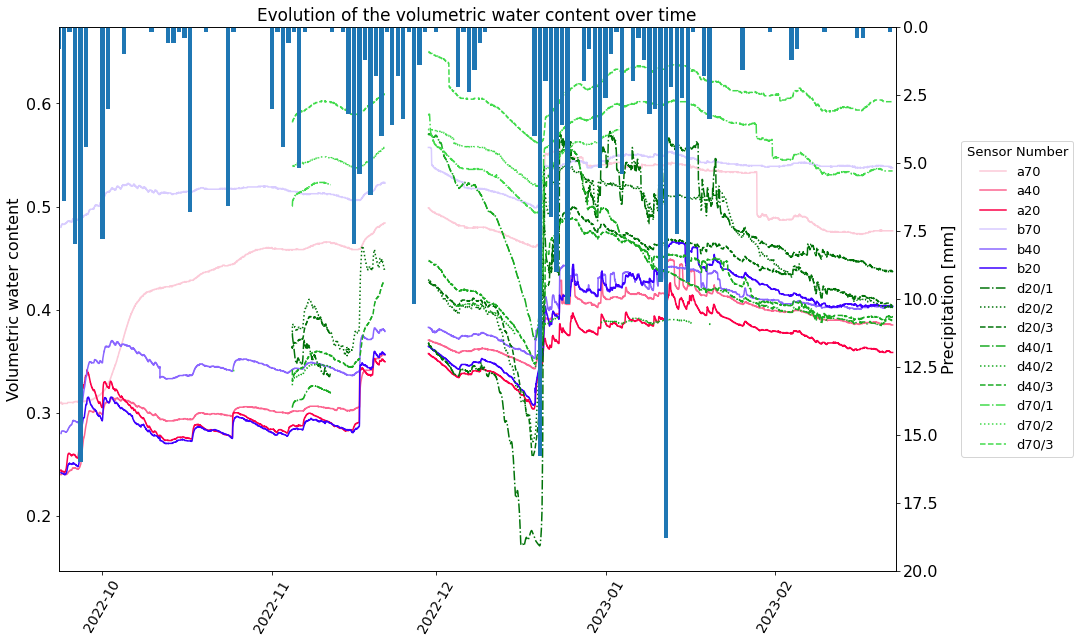

In [16]:
date1=datetime.date(2022,9,23)
date2=datetime.date(2023,2,23)
ftsz=16

fig, ax= plt.subplots(figsize=(15,10))
axb=ax.twinx()

ax.plot(Timestamp, a70, label='a70', color='#fccad8')
ax.plot(Timestamp, a40, label='a40', color='#fc6590')
ax.plot(Timestamp, a20, label='a20', color='#fc0048')
ax.plot(Timestamp, b70, label='b70', color='#d8ccff')
ax.plot(Timestamp, b40, label='b40', color ='#8a66ff')
ax.plot(Timestamp, b20, label='b20', color='#3c00ff')

ax.plot(Timestamp, d20w1, label='d20/1', color='#017309', linestyle = 'dashdot')
ax.plot(Timestamp, d20w2, label='d20/2', color='#017309', linestyle = 'dotted')
ax.plot(Timestamp, d20w3, label='d20/3', color='#017309', linestyle = 'dashed')

ax.plot(Timestamp, d40w1, label='d40/1', color='#1aab23', linestyle = 'dashdot')
ax.plot(Timestamp, d40w2, label='d40/2', color='#1aab23', linestyle = 'dotted')
ax.plot(Timestamp, d40w3, label='d40/3', color='#1aab23', linestyle = 'dashed')

ax.plot(Timestamp, d70w1, label='d70/1', color='#42db4c', linestyle = 'dashdot')
ax.plot(Timestamp, d70w2, label='d70/2', color='#42db4c', linestyle = 'dotted')
ax.plot(Timestamp, d70w3, label='d70/3', color='#42db4c', linestyle = 'dashed')

ax.set_title('Evolution of the volumetric water content over time', fontsize = ftsz+1)
ax.legend(title='Sensor Number',title_fontsize = ftsz-3, bbox_to_anchor = (1.22, 0.5), loc='center right', fontsize=ftsz-3)
ax.set_ylabel('Volumetric water content', fontsize= ftsz)
ax.tick_params(axis='x', which='both', labelsize=ftsz-2,rotation=60)
ax.tick_params(axis='y', which='both', labelsize=ftsz)
axb.bar(climday['date'],climday.precipitation_sum)
axb.set_ylim([0, 20])
axb.invert_yaxis()
axb.set_ylabel('Precipitation [mm]', fontsize= ftsz)
axb.tick_params(axis='x', which='both', labelsize=ftsz)
axb.tick_params(axis='y', which='both', labelsize=ftsz)

axb.set_xlim([date1,date2])

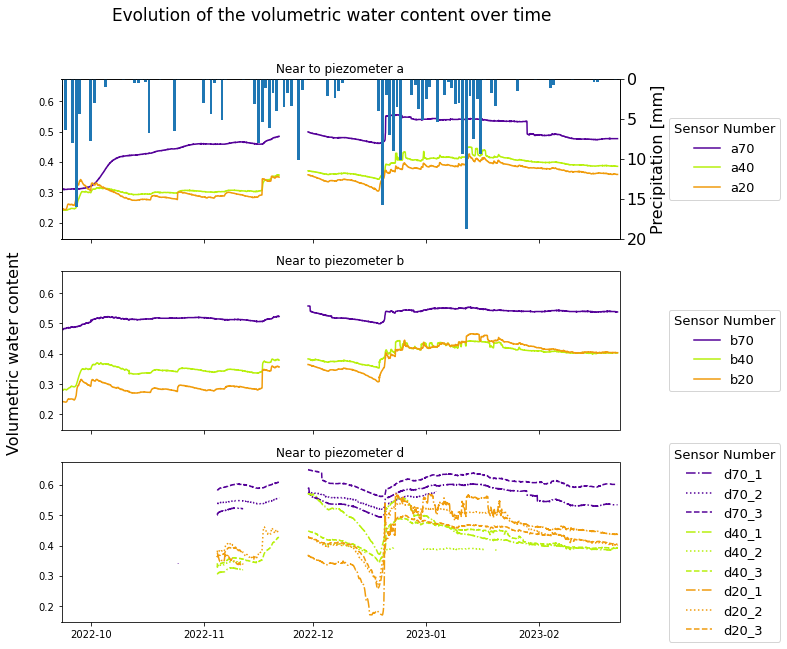

In [17]:
date1=datetime.date(2022,9,23)
date2=datetime.date(2023,2,23)
ftsz=16

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=(10,10))
fig.suptitle('Evolution of the volumetric water content over time', fontsize = ftsz+1)
axb=ax1.twinx()
ax1.plot(Timestamp, a70, label='a70', color='#550299')
ax1.plot(Timestamp, a40, label='a40', color='#b7f00c')
ax1.plot(Timestamp, a20, label='a20', color='#f09c0c')
ax1.set_title('Near to piezometer a')
ax1.legend(title='Sensor Number',title_fontsize = ftsz-3, bbox_to_anchor = (1.3, 0.5), loc='center right', fontsize=ftsz-3)
axb.bar(climday['date'],climday.precipitation_sum)
axb.set_ylim([0, 20])
axb.invert_yaxis()
axb.set_ylabel('Precipitation [mm]', fontsize= ftsz)
axb.tick_params(axis='x', which='both', labelsize=ftsz)
axb.tick_params(axis='y', which='both', labelsize=ftsz)
axb.set_xlim([date1,date2])

ax2.plot(Timestamp, b70, label='b70', color='#550299')
ax2.plot(Timestamp, b40, label='b40', color ='#b7f00c')
ax2.plot(Timestamp, b20, label='b20', color='#f09c0c')
ax2.set_title('Near to piezometer b')
ax2.legend(title='Sensor Number',title_fontsize = ftsz-3, bbox_to_anchor = (1.3, 0.5), loc='center right', fontsize=ftsz-3)

ax3.plot(Timestamp, d70w1, label='d70_1', color='#550299', linestyle = 'dashdot')
ax3.plot(Timestamp, d70w2, label='d70_2', color='#550299', linestyle = 'dotted')
ax3.plot(Timestamp, d70w3, label='d70_3', color='#550299', linestyle = 'dashed')

ax3.plot(Timestamp, d40w1, label='d40_1', color='#b7f00c', linestyle = 'dashdot')
ax3.plot(Timestamp, d40w2, label='d40_2', color='#b7f00c', linestyle = 'dotted')
ax3.plot(Timestamp, d40w3, label='d40_3', color='#b7f00c', linestyle = 'dashed')

ax3.plot(Timestamp, d20w1, label='d20_1', color='#f09c0c', linestyle = 'dashdot')
ax3.plot(Timestamp, d20w2, label='d20_2', color='#f09c0c', linestyle = 'dotted')
ax3.plot(Timestamp, d20w3, label='d20_3', color='#f09c0c', linestyle = 'dashed')
ax3.set_title('Near to piezometer d')
ax3.legend(title='Sensor Number',title_fontsize = ftsz-3, bbox_to_anchor = (1.3, 0.5), loc='center right', fontsize=ftsz-3)

fig.text(0.06, 0.5, 'Volumetric water content', ha='center', va='center', fontsize= ftsz, rotation='vertical')

plt.savefig("VWC.png", bbox_inches = 'tight')


# Read manual measurements

In [19]:
# Read manually measured water dephts for inspection of the data    
file_obs = os.path.join(path, 'GravimetricWaterContent.xlsx')
df_info = pd.read_excel(file_obs)
df_info['Date']=pd.to_datetime(df_info['Date'],dayfirst=True)
(df_info.Date)
df_info2=df_info[df_info.Date.notnull()]
df_info2=df_info2.reset_index(drop=True)
df_info2_a=df_info2.iloc[0:6]
print(df_info2_a)
df_info2_b=df_info2.iloc[6:12]
print(df_info2_b)
df_info2_d=df_info2.iloc[15:18]

         Date Sample  WetWeight  Unnamed: 3  DryWeight  Unnamed: 5  MassWater  \
0  2022-12-20    A70      198.6       193.8      165.2       160.4       33.4   
1  2022-12-20    A40      162.5       157.7      136.1       131.3       26.4   
2  2022-12-20    A20      180.9       176.1      145.8       141.0       35.1   
3  2023-02-22    A70      162.7       158.0      136.2       131.5       26.5   
4  2023-02-22    A40      170.2       165.5      138.8       134.1       31.4   
5  2023-02-22    A20      157.2       152.5      128.3       123.6       28.9   
6  2022-12-20    B70      198.1       193.3      164.0       159.2       34.1   
7  2022-12-20    B40      193.4       188.6      163.6       158.8       29.8   
8  2022-12-20    B20      177.6       172.8      148.2       143.4       29.4   
9  2023-02-22    B70      178.4       173.7      149.2       144.5       29.2   
10 2023-02-22    B40      156.9       152.2      128.4       123.7       28.5   
11 2023-02-22    B20      14

In [36]:
# Read manually measured water dephts for inspection of the data    
file_obs = os.path.join(path, 'VolumetricWaterContent.xlsx')
df_info = pd.read_excel(file_obs)
df_info['Date']=pd.to_datetime(df_info['Date'],dayfirst=True)
(df_info.Date)
df_info2=df_info[df_info.Date.notnull()]
df_info2=df_info2.reset_index(drop=True)
df_info2_av=df_info2.iloc[0:3]
print(df_info2_av)
df_info2_bv=df_info2.iloc[3:4]
print(df_info2_bv)
df_info2_dv=df_info2.iloc[4:7]
print(df_info2_dv)

        Date Sample  WetWeight  Unnamed: 3  DryWeight  Unnamed: 5    VWC  \
0 2023-02-22    A20      192.8       188.1      159.1       154.4  0.337   
1 2023-02-22    A40      211.2       206.5      175.8       171.1  0.354   
2 2023-02-22    A70      225.9       221.2      187.1       182.4  0.388   

   Empty  
0    4.7  
1    NaN  
2    NaN  
        Date Sample  WetWeight  Unnamed: 3  DryWeight  Unnamed: 5    VWC  \
3 2023-02-22    B20      197.5       192.8      161.7       157.0  0.358   

   Empty  
3    NaN  
        Date Sample  WetWeight  Unnamed: 3  DryWeight  Unnamed: 5    VWC  \
4 2023-02-22    D20      199.7       195.0      170.5       165.8  0.292   
5 2023-02-22    D40      199.0       194.3      168.1       163.4  0.309   
6 2023-02-22    D70      195.8       191.1      161.3       156.6  0.345   

   Empty  
4    NaN  
5    NaN  
6    NaN  


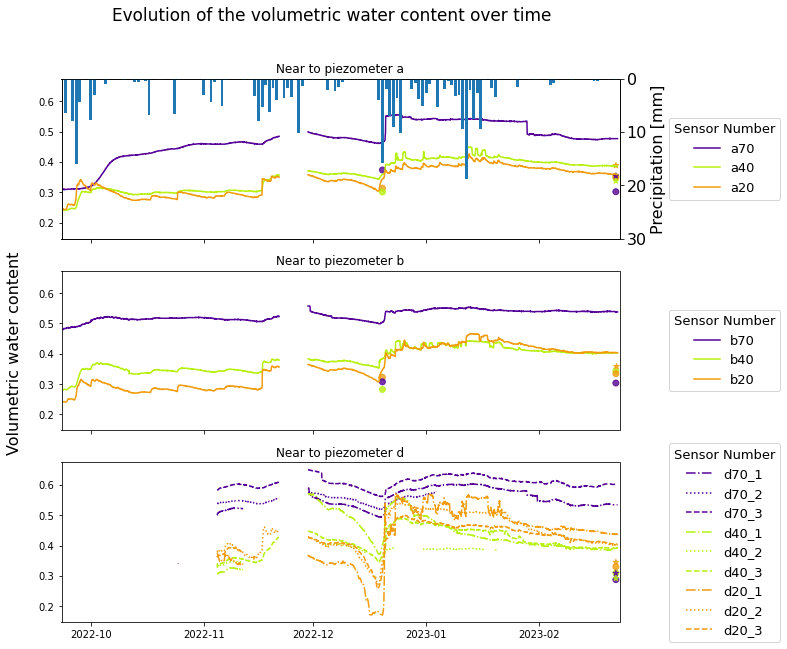

In [37]:
date1=datetime.date(2022,9,23)
date2=datetime.date(2023,2,23)
ftsz=16
colors = {'#550299','#b7f00c','#f09c0c','#550290','#b7f01c','#f09c1c'}
colorsd = {'#550299','#b7f00c','#f09c0c'}
colors1 = {'#f09c0c'}

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=(10,10))
fig.suptitle('Evolution of the volumetric water content over time', fontsize = ftsz+1)
axb=ax1.twinx()
ax1.plot(Timestamp, a70, label='a70', color='#550299')
ax1.plot(Timestamp, a40, label='a40', color='#b7f00c')
ax1.plot(Timestamp, a20, label='a20', color='#f09c0c')
ax1.scatter(df_info2_a.Date, df_info2_a.iloc[:,8],c=colors, alpha=.8, marker='o')
ax1.scatter(df_info2_av.Date, df_info2_av.iloc[:,6],c=colorsd, alpha=.8, marker='*')
ax1.set_title('Near to piezometer a')
ax1.legend(title='Sensor Number',title_fontsize = ftsz-3, bbox_to_anchor = (1.3, 0.5), loc='center right', fontsize=ftsz-3)
axb.bar(climday['date'],climday.precipitation_sum)
axb.set_ylim([0, 30])
axb.invert_yaxis()
axb.set_ylabel('Precipitation [mm]', fontsize= ftsz)
axb.tick_params(axis='x', which='both', labelsize=ftsz)
axb.tick_params(axis='y', which='both', labelsize=ftsz)
axb.set_xlim([date1,date2])

ax2.plot(Timestamp, b70, label='b70', color='#550299')
ax2.plot(Timestamp, b40, label='b40', color ='#b7f00c')
ax2.plot(Timestamp, b20, label='b20', color='#f09c0c')
ax2.scatter(df_info2_b.Date, df_info2_b.iloc[:,8],c=colors, alpha=.8, marker='o')
ax2.scatter(df_info2_bv.Date, df_info2_bv.iloc[:,6],c=colors1, alpha=.8, marker='*')
ax2.set_title('Near to piezometer b')
ax2.legend(title='Sensor Number',title_fontsize = ftsz-3, bbox_to_anchor = (1.3, 0.5), loc='center right', fontsize=ftsz-3)

ax3.plot(Timestamp, d70w1, label='d70_1', color='#550299', linestyle = 'dashdot')
ax3.plot(Timestamp, d70w2, label='d70_2', color='#550299', linestyle = 'dotted')
ax3.plot(Timestamp, d70w3, label='d70_3', color='#550299', linestyle = 'dashed')

ax3.plot(Timestamp, d40w1, label='d40_1', color='#b7f00c', linestyle = 'dashdot')
ax3.plot(Timestamp, d40w2, label='d40_2', color='#b7f00c', linestyle = 'dotted')
ax3.plot(Timestamp, d40w3, label='d40_3', color='#b7f00c', linestyle = 'dashed')

ax3.plot(Timestamp, d20w1, label='d20_1', color='#f09c0c', linestyle = 'dashdot')
ax3.plot(Timestamp, d20w2, label='d20_2', color='#f09c0c', linestyle = 'dotted')
ax3.plot(Timestamp, d20w3, label='d20_3', color='#f09c0c', linestyle = 'dashed')
ax3.scatter(df_info2_d.Date, df_info2_d.iloc[:,8],c=colorsd, alpha=.8, marker='o')
ax3.scatter(df_info2_dv.Date, df_info2_dv.iloc[:,6],c=colorsd, alpha=.8, marker='*')
ax3.set_title('Near to piezometer d')
ax3.legend(title='Sensor Number',title_fontsize = ftsz-3, bbox_to_anchor = (1.3, 0.5), loc='center right', fontsize=ftsz-3)

fig.text(0.06, 0.5, 'Volumetric water content', ha='center', va='center', fontsize= ftsz, rotation='vertical')

plt.savefig("VWC.png", bbox_inches = 'tight')